# Mushroom Classification CNN

In [111]:
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1) Настройка путей и очистка старых папок

In [ ]:
# Путь к исходному датасету с изображениями грибов
dataset_dir = './Mushrooms'

# Получаем список всех классов (папок) внутри датасета
classes = os.listdir(dataset_dir)
print(f"Найдено {len(classes)} классов:", classes)

# Определяем базовую папку для разделённого датасета
base_dir = './Mushrooms_split'

# Папки для тренировочного, валидационного и тестового наборов
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Создаём структуру папок для разделённого датасета
for dir_path in [train_dir, val_dir, test_dir]:
    # Если папка уже существует, удаляем её, чтобы начать с чистого состояния
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    # Создаём основную папку (train/val/test)
    os.makedirs(dir_path)
    # Для каждого класса создаём подкаталог внутри train/val/test
    for cls in classes:
        os.makedirs(os.path.join(dir_path, cls))


Найдено 9 классов: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


## 2) Разделение на train/val/test

In [ ]:
# Функция для проверки целостности изображения
# Открываем изображение через PIL и вызываем verify(), чтобы убедиться, что файл не повреждён
# Если изображение можно открыть и проверить, возвращаем True, иначе False
def is_image_ok(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        return False

# Пропорции для разделения датасета на train/val/test
# 70% для обучения, 15% для валидации, 15% для теста
split_ratio = [0.7, 0.15, 0.15]

# Проходим по каждому классу (папке) в исходном датасете
for cls in classes:
    # Полный путь к папке с изображениями конкретного класса
    class_path = os.path.join(dataset_dir, cls)
    
    # Получаем список изображений, оставляя только те, которые не повреждены
    images = [img for img in os.listdir(class_path) if is_image_ok(os.path.join(class_path, img))]
    
    # Перемешиваем изображения случайным образом для равномерного распределения по наборам
    np.random.shuffle(images)
    
    # Считаем общее количество доступных (неповреждённых) изображений
    n_total = len(images)
    
    # Вычисляем количество изображений для train/val/test по заданным пропорциям
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)
    n_test = n_total - n_train - n_val  # остаток идёт в тестовый набор

    # Разделяем список изображений на три части
    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train+n_val]
    test_imgs = images[n_train+n_val:]

    # Копируем изображения в соответствующие папки train
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, cls, img))
    # Копируем изображения в папки val
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, cls, img))
    # Копируем изображения в папки test
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, cls, img))

print("Датасет разделён")


Датасет разделён


## 3) Генератор данных

In [ ]:
# Создаём объект ImageDataGenerator с нормализацией пикселей
# Значения пикселей будут приведены к диапазону [0, 1]
datagen = ImageDataGenerator(rescale=1./255)

# Генератор
def safe_flow_from_directory(generator, directory, target_size=(128,128), batch_size=32, class_mode='categorical', shuffle=True):
    # Получаем отсортированный список классов (папок) в директории
    classes = sorted(os.listdir(directory))
    
    # Списки для хранения путей к файлам и их меток
    filepaths = []
    labels = []
    
    # Словарь: имя класса -> числовая метка
    class_indices = dict(zip(classes, range(len(classes))))
    
    # Проходим по каждому классу и собираем пути к файлам и соответствующие метки
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        for fname in os.listdir(cls_dir):
            filepaths.append(os.path.join(cls_dir, fname))
            labels.append(class_indices[cls])
    
    # Преобразуем списки в numpy-массивы для удобства индексации
    filepaths = np.array(filepaths)
    labels = np.array(labels)
    
    num_samples = len(filepaths)
    indices = np.arange(num_samples)
    
    # Бесконечный цикл генератора
    while True:
        # Если требуется, перемешиваем индексы для случайного порядка
        if shuffle:
            np.random.shuffle(indices)
        
        # Создаём батчи
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_x = []  # сюда будут складываться изображения
            batch_y = []  # сюда метки
            
            for i in batch_indices:
                try:
                    # Пытаемся загрузить изображение и изменить его размер
                    img = load_img(filepaths[i], target_size=target_size)
                    x = img_to_array(img) / 255.0  # нормализуем пиксели
                    batch_x.append(x)
                    batch_y.append(labels[i])
                except:
                    continue
            
            # Если батч пустой, пропускаем
            if len(batch_x) == 0:
                continue
            
            # Преобразуем списки в numpy-массивы для передачи в Keras
            batch_x = np.array(batch_x)
            # Преобразуем метки в one-hot encoding
            batch_y = to_categorical(np.array(batch_y), num_classes=len(classes))
            
            # Возвращаем батч
            yield batch_x, batch_y


## 4) Определение моделей

In [ ]:
# Модель 1 — базовая CNN
def create_model1():
    model = Sequential([
        # Первый сверточный слой, 32 фильтра 3x3, ReLU активация
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        # Подвыборка (снижение размера признаков)
        MaxPooling2D(2,2),
        
        # Второй сверточный слой, 64 фильтра
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        
        # Третий сверточный слой, 128 фильтров
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        
        # Полносвязный слой с 256 нейронами и ReLU
        Dense(256, activation='relu'),
        
        # Dropout для регуляризации (случайное обнуление 50% нейронов)
        Dropout(0.5),
        
        # Выходной слой с количеством нейронов = числу классов и softmax активацией
        Dense(len(classes), activation='softmax')
    ])
    
    # Компиляция модели: Adam optimizer, кросс-энтропия для многоклассовой классификации, метрика accuracy
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Модель 2 — с BatchNormalization и бОльшим Dense слоем
def create_model2():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        # BatchNormalization нормализует активации
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Flatten(),
        # Более крупный полносвязный слой с 512 нейронами
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ])
    
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Модель 3 — CNN с 4 сверточными слоями и увеличенным Dropout
def create_model3():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        
        # Четвёртый сверточный слой для извлечения более сложных признаков
        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        
        Flatten(),
        Dense(512, activation='relu'),
        # Более сильная регуляризация (Dropout 60%)
        Dropout(0.6),
        Dense(len(classes), activation='softmax')
    ])
    
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Модель 1 — базовая CNN с 3 сверточными слоями, небольшим Dense слоем и умеренным Dropout.

Модель 2 — добавлена BatchNormalization для стабильности обучения, увеличен Dense слой для большей ёмкости модели.

Модель 3 — более глубокая сеть с 4 сверточными слоями и большим Dropout для борьбы с переобучением.

## 5) Обучение моделей

In [ ]:
# Создаём список моделей
models = [create_model1(), create_model2(), create_model3()]

# Соответствующие batch_size для каждой модели
batch_sizes = [32, 64, 32]

# Списки для хранения истории обучения и результатов на тесте
histories = []
test_results = []

# Проходим по всем моделям по очереди
for i, model in enumerate(models):
    print(f"\n=== Обучение модели {i+1} ===")
    
    # Получаем batch_size для текущей модели
    batch_size = batch_sizes[i]
    
    # Создаём генераторы для обучения, валидации и теста
    # Для тестового генератора shuffle=False, чтобы порядок соответствовал меткам
    train_gen = safe_flow_from_directory(datagen, train_dir, batch_size=batch_size)
    val_gen = safe_flow_from_directory(datagen, val_dir, batch_size=batch_size)
    test_gen = safe_flow_from_directory(datagen, test_dir, batch_size=batch_size, shuffle=False)
    
    # Вычисляем количество шагов (steps) для fit и evaluate
    # steps = общее количество изображений в наборе / batch_size
    steps_train = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in classes) // batch_size
    steps_val = sum(len(os.listdir(os.path.join(val_dir, cls))) for cls in classes) // batch_size
    steps_test = sum(len(os.listdir(os.path.join(test_dir, cls))) for cls in classes) // batch_size
    
    # Обучение модели на тренировочном наборе с валидацией
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_train,
        epochs=10,
        validation_data=val_gen,
        validation_steps=steps_val
    )
    
    # Сохраняем историю обучения для последующего анализа
    histories.append(history)
    
    # Оценка модели на тестовом наборе
    test_loss, test_acc = model.evaluate(test_gen, steps=steps_test)
    
    # Сохраняем результаты
    test_results.append((test_loss, test_acc))
    
    # Выводим результаты
    print(f"Модель {i+1} - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


c:\Users\Zver\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Обучение модели 1 ===
Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 103s 697ms/step - accuracy: 0.2335 - loss: 2.0425 - val_accuracy: 0.2712 - val_loss: 1.9557
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 236ms/step - accuracy: 0.3001 - loss: 1.9230 - val_accuracy: 0.3347 - val_loss: 1.8208
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 234ms/step - accuracy: 0.3481 - loss: 1.8286 - val_accuracy: 0.3518 - val_loss: 1.7729
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: 0.3646 - loss: 1.7557 - val_accuracy: 0.3835 - val_loss: 1.7306
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.4030 - loss: 1.6858 - val_accuracy: 0.3969 - val_loss: 1.7076
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.4103 - loss: 1.6411 - val_accuracy: 0.3887 - val_loss: 1.6932
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.4401 - loss: 1.5800 - val_accuracy: 0.4340 - val_loss: 1.6463
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step 

## 6) Сравнительный анализ

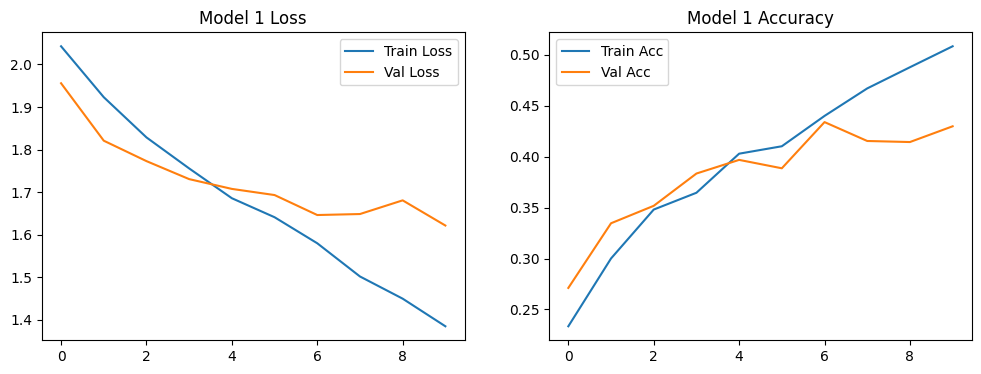

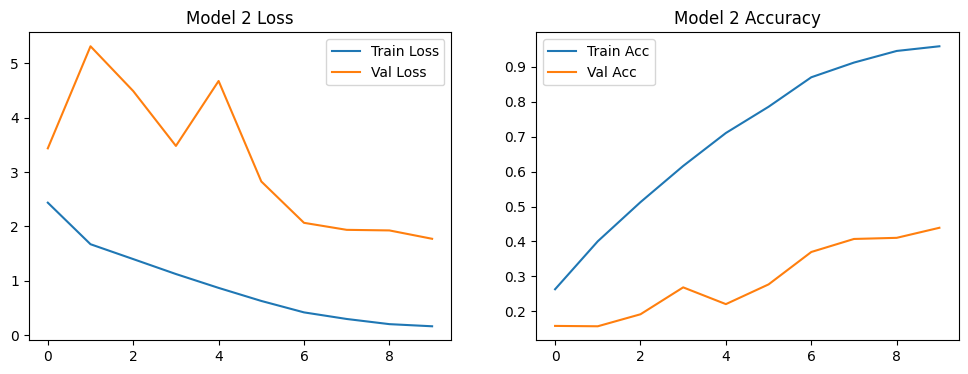

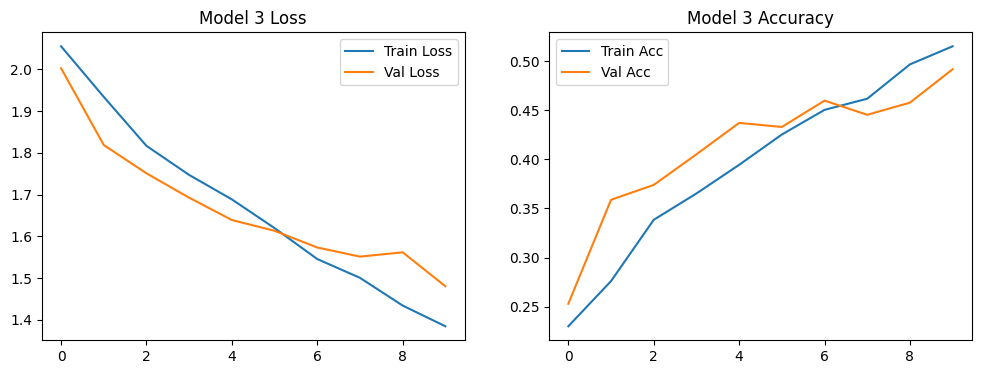

Сравнительные результаты на тесте:
Модель 1 — Test Loss: 1.6466, Test Acc: 0.4279
Модель 2 — Test Loss: 1.7503, Test Acc: 0.4400
Модель 3 — Test Loss: 1.5103, Test Acc: 0.4581


In [117]:
for i, history in enumerate(histories):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Model {i+1} Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Model {i+1} Accuracy')
    plt.legend()
    plt.show()

print("Сравнительные результаты на тесте:")
for i, (loss, acc) in enumerate(test_results):
    print(f"Модель {i+1} — Test Loss: {loss:.4f}, Test Acc: {acc:.4f}")

## 7) Confusion matrix


=== Confusion Matrix для модели 1 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━

<Figure size 1000x1000 with 0 Axes>

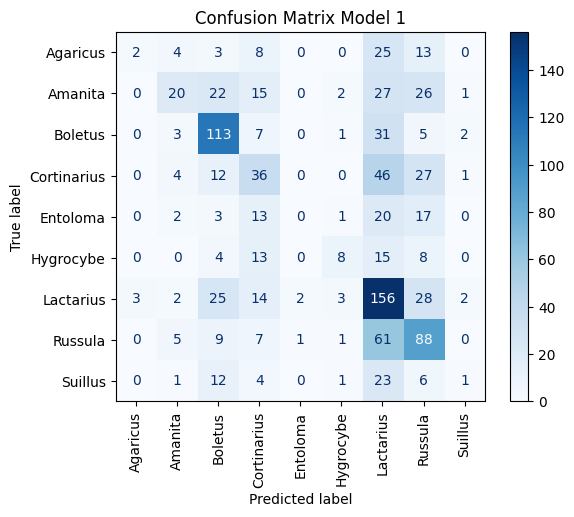


=== Confusion Matrix для модели 2 ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


<Figure size 1000x1000 with 0 Axes>

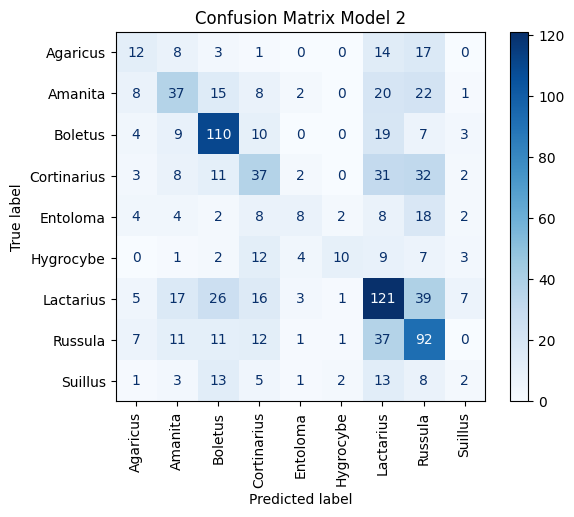


=== Confusion Matrix для модели 3 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━

<Figure size 1000x1000 with 0 Axes>

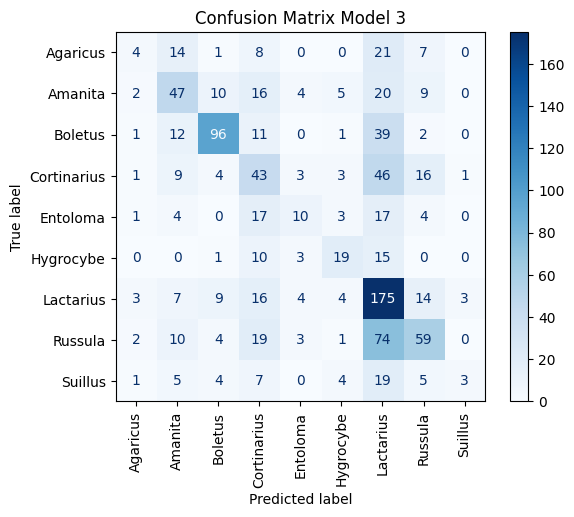

In [118]:
for i, model in enumerate(models):
    print(f"\n=== Confusion Matrix для модели {i+1} ===")
    batch_size = batch_sizes[i]
    test_gen = safe_flow_from_directory(datagen, test_dir, batch_size=batch_size, shuffle=False)
    
    y_true = []
    y_pred = []
    steps_test = sum(len(os.listdir(os.path.join(test_dir, cls))) for cls in classes)
    
    for batch_x, batch_y in test_gen:
        preds = model.predict(batch_x)
        y_true.extend(np.argmax(batch_y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        if len(y_true) >= steps_test:
            break
    y_true = y_true[:steps_test]
    y_pred = y_pred[:steps_test]
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(10,10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Confusion Matrix Model {i+1}')
    plt.show()